In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import datetime
import numpy as np
import scipy.stats as sps
from scipy.spatial.distance import cdist
from scipy import stats
from sklearn import linear_model
import statsmodels.api as sm
from patsy.builtins import Q
from patsy import ModelDesc, Term, LookupFactor
import statsmodels.formula.api as smf
import math

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)





Group members: Bjarki Þór Hilmarsson, Guðmundur Guðbjarnason, Ketill Ingólfsson, Sverrir Ólafur Torfason


Lets start by loading the dataset. This dataset is from a research that was done at MIT which subject was focused on clustering cities around the world by their transportation infrastructure and means.

After a quick glance through it we notice that some attributes (columns) have quite a lot of NaN values. To deal with that we decided to use the Typology and replace the Nan value with the mean of the countries typology. In some cases the countries in the same typology all have a Nan value in the same attribute, in that case the mean of the continent is used.
What we also do is make dummy variables of the typology and continent columns to use later on in the prediction part

Then the dataset is immediately split up in to two parts, training and testing.

In [2]:
#read the xls file in pandas
df = pd.read_excel('Cities.xlsx', index_col=0)
df = df.set_index('City')

df['Typology'] = df['Typology'].astype('category')
df['Continents'] = df['Continents'].astype('category')


df = df.join(pd.get_dummies(df['Typology']))
df = df.join(pd.get_dummies(df['Continents']))


dfAVG = df.groupby("Typology").transform(lambda x: x.fillna(x.mean()))
dfAVG.insert(4, "Continents", df["Continents"], True)

dfAVG = df.groupby("Continents").transform(lambda x: x.fillna(x.mean()))


split=int(len(dfAVG)*0.75)
trainingSplit=dfAVG[:split]
test=dfAVG[split:]

Let's start by visualizing the CO2 emissions, just to see what they look like

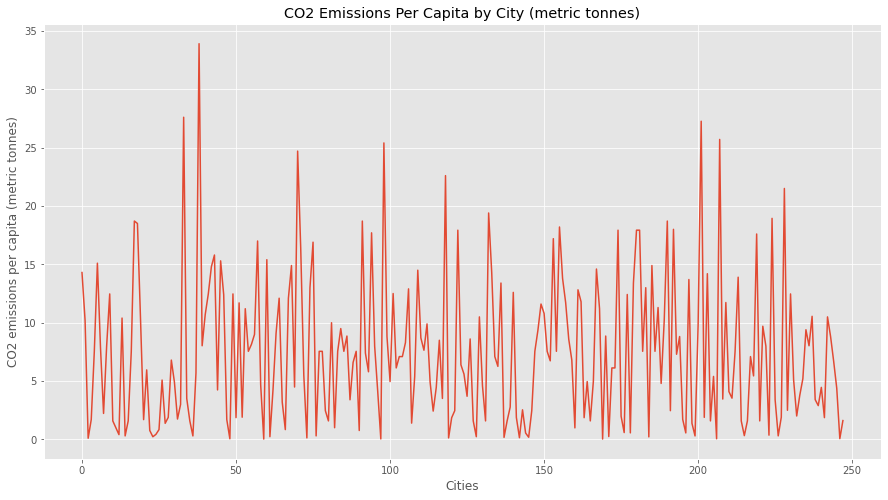

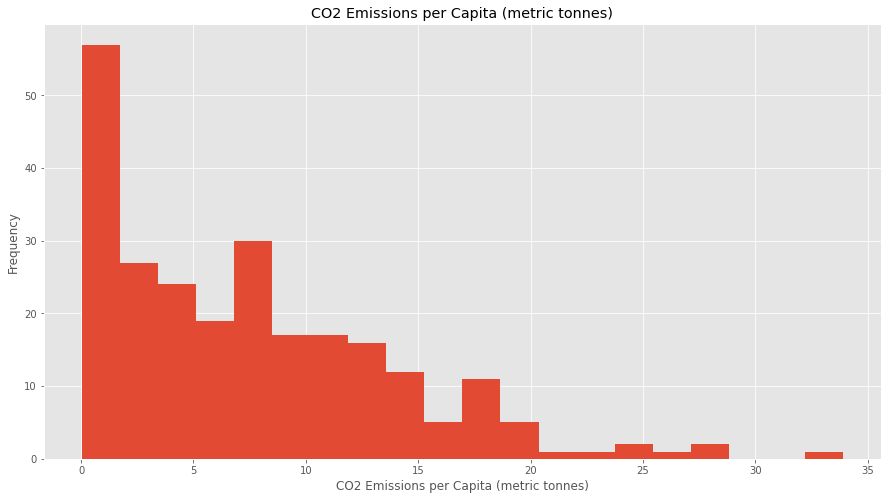

In [3]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(trainingSplit['CO2 Emissions per Capita (metric tonnes)'])), trainingSplit['CO2 Emissions per Capita (metric tonnes)'])

ax.set(xlabel='Cities', ylabel='CO2 emissions per capita (metric tonnes)',
       title='CO2 Emissions Per Capita by City (metric tonnes)')
plt.show()

n, bins, patches=plt.hist(trainingSplit['CO2 Emissions per Capita (metric tonnes)'], bins=20)
plt.title("CO2 Emissions per Capita (metric tonnes)")
plt.ylabel("Frequency")
plt.xlabel("CO2 Emissions per Capita (metric tonnes)")
plt.show()

We see that most of the values fall between 0-12 and that we have a few outliers that are emitting 20+.

Now that we have inspected our data, the next step is to evaluate what attributes should be use in the regression model along with the dummy variables. After playing around with a validation set seen below, we chose to select the variables that have more than +-0.4 correlation with CO2 emission per capita.
We drop the Pollution index as instructed and also the clusterID as we have made dummies for that.

In [4]:
correlation = trainingSplit[trainingSplit.columns[:73]].corr()['CO2 Emissions per Capita (metric tonnes)']
corre_df = correlation.to_frame()
corre_df = corre_df.rename(columns={'CO2 Emissions per Capita (metric tonnes)': 'CO2corr'})
print(corre_df.head())
corre_df1 = corre_df[corre_df.CO2corr >= 0.4]
corre_df2 = corre_df[corre_df.CO2corr <= -0.4]
corre_df = corre_df1.append(corre_df2)

corre_df = corre_df.drop(index='CO2 Emissions per Capita (metric tonnes)')
corre_df = corre_df.drop(index='Pollution Index ')
corre_df = corre_df.drop(index='clusterID')

listi = corre_df.T.columns.tolist()
dfAVG.head()


                               CO2corr
cityID                        0.363553
clusterID                     0.448332
Car Modeshare (%)             0.643755
Public Transit Modeshare (%) -0.498764
Walking Modeshare (%)        -0.603576


,cityID,clusterID,Car Modeshare (%),Public Transit Modeshare (%),Walking Modeshare (%),Gasoline Pump Price (USD/liter),Road Deaths Rate (per 1000),Subway Length (km),Subway Length Density (per km),Subway Stations per Hundred Thousand,Subway Ridership per Capita,Subway Age (years),BRT Length (km),BRT System Length Density (per km),BRT Stations per Hundred Thousand Persons,BRT Fleet per Hundred Thousand Persons,BRT Annual Ridership per Capita,BRT Age (years),Bikeshare Stations per Hundred Thousand Persons,Bikeshare Number of Bikes,Bikeshare Bicycles per Hundred Thousand Persons,Bikeshare Age (years),Congestion (%),Congestion AM Peak (%),Congestion PM Peak (%),Traffic Index,Travel Time Index,Inefficiency Index,Population,Land Area (sq. km),Population Density (per sq. km),Population Change 1990 – 2000,Population Change 2000 – 2010,Population Change 2010 – 2020,Population Change 2020 – 2025,Urbanization Rate 2015 (%),Urbanization Rate Change 2015 – 2025 (pp),GDP per Capita (USD),Unemployment Rate (%),Cost of Living Index,Rent Index,Grocery Index,Restaurant Price Index,Local Purchasing Power Index,Gini Coefficient,Poverty Rate (%),Life Expectancy (years),Safety Index,Internet Penetration,Digital Penetration,Innovation Index,Smartphone Penetration (%),CO2 Emissions per Capita (metric tonnes),Pollution Index,Street length total (m),Street Length Density (m/sq. km),Street Length Average (m),Intersection Count,Intersection Density (per sq. km),Degree Average,Streets per Node,Circuity,Self-Loop Proportion,Highway Proportion,Metro Propensity Factor,BRT Propensity Factor,BikeShare Propensity Factor,Development Factor,Sustainability Factor,Population Factor,Congestion Factor,Sprawl Factor,Network Density Factor,Auto Innovative,Auto Sprawl,BusTransit Dense,BusTransit Sprawl,Congested Boomer,Congested Emerging,Hybrid Giant,Hybrid Moderate,MassTransit Heavyweight,MassTransit Moderate,MetroBike Emerging,MetroBike Giant,AF,AS,EU,NOAM,OC,SA
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Baltimore(MD),285,7,85.000000,6.1,2.600000,0.66,8.5,24.9,0.013409,0.615385,6.417582,34,0.0,0.000000,0.000000,0.000000,0.000000,0.0,2.197802,696.396552,0.00000,2.0,19.000000,33.000000,46.000000,148.970000,36.900000,150.220000,2275000,1857,1200,233673,332204,399059,195708,81.6,1.7,58789.0,7.20,77.330000,48.580000,76.480000,78.28000,150.690000,0.443000,22.900000,78.8,31.190000,81.0,0.78,45.000000,72.000000,14.300000,40.885000,7468900.983,7.604833e+09,148.013337,28660.0,1018.199702,5.021972,2.869906,1.067736,0.007910,0.041018,0.160848,0.176867,0.360637,0.796264,0.355964,0.081956,0.180085,0.722163,0.425187,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Melbourne,10,8,80.000000,14.0,4.000000,1.11,5.4,0.0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.264223,600.000000,15.17067,2.0,33.000000,55.000000,58.000000,143.120000,35.570000,138.170000,3955000,2543,1500,316060,462816,715525,350883,89.4,1.2,39358.0,5.50,79.040000,44.300000,72.930000,76.07000,139.620000,NaN,NaN,82.0,60.230000,86.9,0.74,50.000000,77.000000,10.200000,26.770000,8636838.530,8.653670e+09,107.503591,48571.0,1001.948856,4.948413,2.876305,1.036985,0.001626,0.014489,0.060387,0.168335,0.363675,0.786174,0.397894,0.082267,0.333173,0.539355,0.558910,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Niamey,186,1,15.165217,9.0,60.000000,1.02,26.4,0.0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,28.250000,59.250000,55.250000,235.470000,48.525000,252.355000,1435000,130,11100,248392,541978,960996,741379,18.7,3.5,427.4,19.38,48.862000,24.916500,42.506000,36.09550,47.542000,0.469444,18.600000,61.8,41.575263,2.4,0.04,28.200000,23.333333,0.106861,77.604000,2134329.200,3.496995e+09,97.860119,13033.0,1638.451450,6.161297,3.187450,1.019423,0.000095,0.000000,0.036220,0.010915,0.343161,0.000000,0.273646,0.248398,0.655464,0.275605,0.410312,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
Hanoi,328,12,8.000000,10.0,23.803958,0.90,24

Now we have a list of variables that corrolate with the target CO2 variable. Lets visualize these corrolated variables vs the CO2 emission

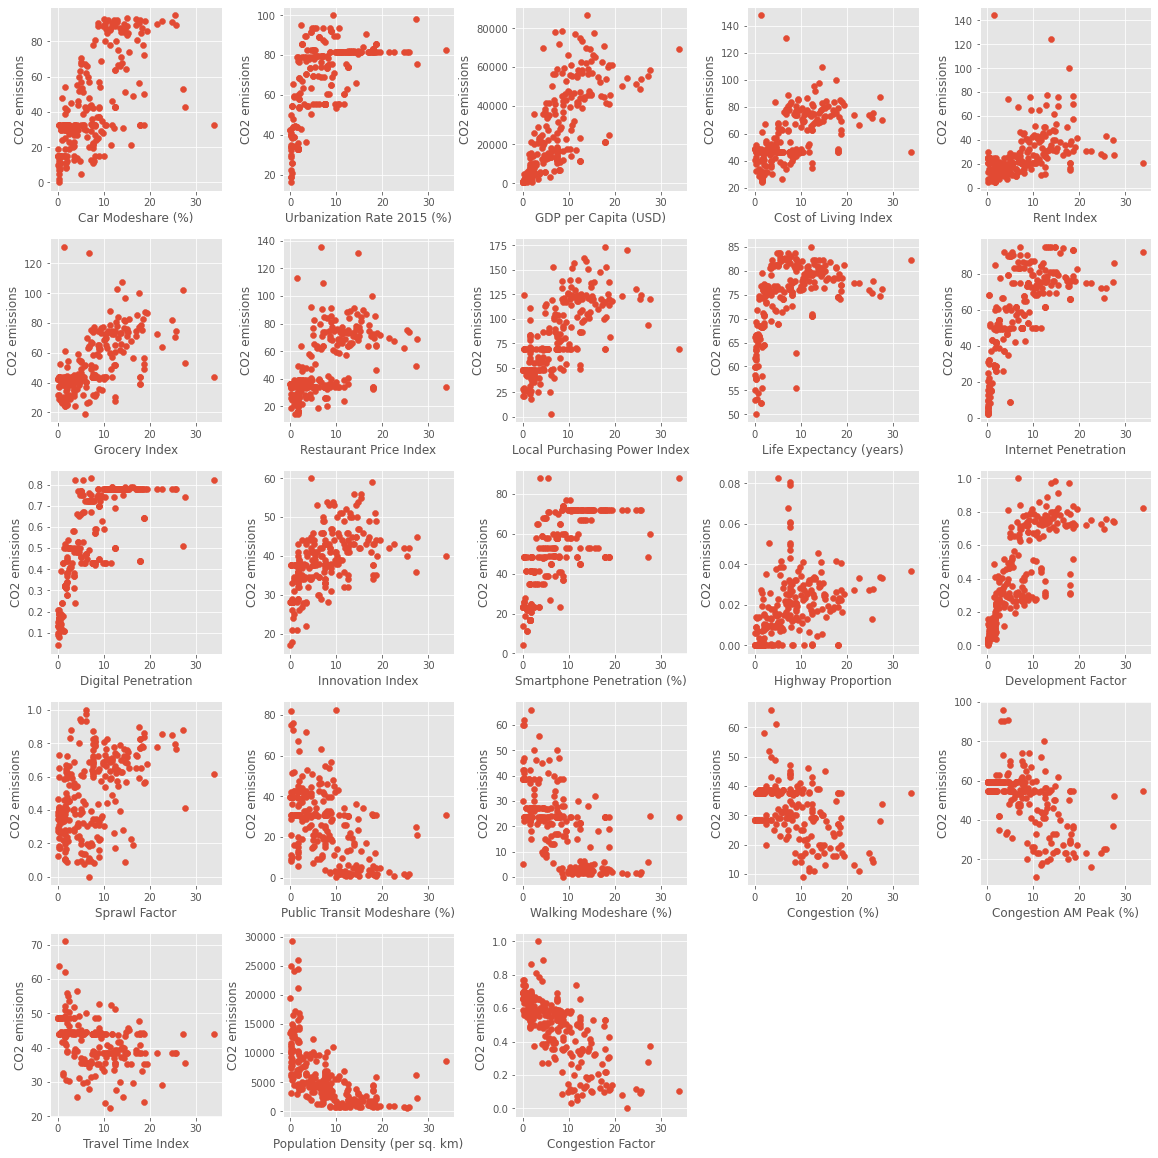

<Figure size 1080x576 with 0 Axes>

In [5]:
dfm = trainingSplit[listi]
att_names = dfm.columns
df_values = dfm.values

plt.figure(figsize=(16,16))
for i,col in enumerate(att_names):
    ax = plt.subplot(5,5,i+1)
    plt.scatter(trainingSplit['CO2 Emissions per Capita (metric tonnes)'],dfm[col])
   # ax.set_title("CO2 vs. " + col)
    plt.ylabel("CO2 emissions")
    plt.xlabel(col)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()
plt.tight_layout()

Let's take a deeper look at them and see how they correlate with each other, do some of them essentially contain the same information and can be removed?

In [6]:
trainingSplit[listi].corr().head()

,Car Modeshare (%),Urbanization Rate 2015 (%),GDP per Capita (USD),Cost of Living Index,Rent Index,Grocery Index,Restaurant Price Index,Local Purchasing Power Index,Life Expectancy (years),Internet Penetration,Digital Penetration,Innovation Index,Smartphone Penetration (%),Highway Proportion,Development Factor,Sprawl Factor,Public Transit Modeshare (%),Walking Modeshare (%),Congestion (%),Congestion AM Peak (%),Travel Time Index,Population Density (per sq. km),Congestion Factor
Car Modeshare (%),1.000000,0.541696,0.672656,0.567420,0.403679,0.637759,0.604965,0.743977,0.486217,0.535586,0.725582,0.522826,0.685404,0.263008,0.727935,0.362658,-0.741527,-0.802530,-0.532102,-0.675638,-0.437291,-0.566967,-0.816884
Urbanization Rate 2015 (%),0.541696,1.000000,0.660835,0.535059,0.334270,0.492328,0.587924,0.499168,0.722366,0.767081,0.809086,0.524876,0.646218,0.304544,0.756239,0.242922,-0.310734,-0.483188,-0.241911,-0.372500,-0.402353,-0.594165,-0.581166
GDP per Capita (USD),0.672656,0.660835,1.000000,0.771960,0.634378,0.760947,0.807666,0.764819,0.659911,0.778860,0.866526,0.772027,0.714838,0.406732,0.942917,0.142185,-0.484672,-0.617171,-0.403745,-0.475613,-0.471109,-0.615415,-0.710449
Cost of Living Index,0.567420,0.535059,0.771960,1.000000,0.834777,0.959230,0.942767,0.632905,0.415633,0.579485,0.635579,0.550504,0.586859,0.269380,0.819953,0.058146,-0.430689,-0.482549,-0.431280,-0.397555,-0.348558,-0.533236,-0.578494
Rent Index,0.403679,0.334270,0.634378,0.834777,1.000000,0.819252,0.741959,0.487770,0.213294,0.386773,0.420851,0.509649,0.424625,0.252978,0.644893,0.164587,-0.331630,-0.369563,-0.238097,-0.210420,-0.163105,-0.352484,-0.343247


Looks like we have some highly correlated ones, lets throw some of them away and add the dummy variables to our list of features to train on.

In [7]:
listiTypo = ['Auto Innovative', 'Auto Sprawl', 'BusTransit Dense', 'BusTransit Sprawl', 'Congested Boomer', 'Congested Emerging', 'Hybrid Giant', 'Hybrid Moderate', 'MassTransit Heavyweight', 'MassTransit Moderate', 'MetroBike Emerging', 'MetroBike Giant']
listiCont = ['AF', 'AS', 'EU', 'NOAM', 'OC', 'SA']

#throwin some higly correlated variables that tell very simular things to another variable
listi.remove('Congestion AM Peak (%)') #Very much like Congestion %
listi.remove('Restaurant Price Index') #Very much like Cost of Living %
listi.remove('Grocery Index') #Very much like Cost of Living
listi.remove('Rent Index') #Cost of Living
listi.remove('Digital Penetration') #Highly correlated with a lot of attributes
listi.remove('Development Factor') #Highly correlated with a lot of attributes

features = listi + listiCont + listiTypo

target = 'CO2 Emissions per Capita (metric tonnes)'

print("So our model is based on the following variables:\n ", features)

So our model is based on the following variables:
  ['Car Modeshare (%)', 'Urbanization Rate 2015 (%)', 'GDP per Capita (USD)', 'Cost of Living Index', 'Local Purchasing Power Index', 'Life Expectancy (years)', 'Internet Penetration', 'Innovation Index', 'Smartphone Penetration (%)', 'Highway Proportion', 'Sprawl Factor', 'Public Transit Modeshare (%)', 'Walking Modeshare (%)', 'Congestion (%)', 'Travel Time Index', 'Population Density (per sq. km)', 'Congestion Factor', 'AF', 'AS', 'EU', 'NOAM', 'OC', 'SA', 'Auto Innovative', 'Auto Sprawl', 'BusTransit Dense', 'BusTransit Sprawl', 'Congested Boomer', 'Congested Emerging', 'Hybrid Giant', 'Hybrid Moderate', 'MassTransit Heavyweight', 'MassTransit Moderate', 'MetroBike Emerging', 'MetroBike Giant']


To test the model variables we have made three validation tests, we use 80% of the training data to train and the remaining 20% to test. Each validation test is split randomly.


In [8]:
from sklearn.model_selection import train_test_split
#Búa til 3 random validation set úr training

train1, test1 = train_test_split(trainingSplit, train_size=0.8)
x_train1, y_train1 = train1[features], train1[target]
x_test1, y_test1 = test1[features], test1[target]

train2, test2 = train_test_split(trainingSplit, train_size=0.8)
x_train2, y_train2 = train2[features], train2[target]
x_test2, y_test2 = test2[features], test2[target]

train3, test3 = train_test_split(trainingSplit, train_size=0.8)
x_train3, y_train3 = train3[features], train3[target]
x_test3, y_test3 = test3[features], test3[target]

from sklearn.linear_model import LinearRegression
lm1 = LinearRegression()
lm1.fit(x_train1, y_train1)
print("Linear regression score for training set 1: ", lm1.score(x_train1, y_train1))
print("Linear regression score for validation set 1: ", lm1.score(x_test1, y_test1))
print("")
lm2 = LinearRegression()
lm2.fit(x_train2, y_train2)
print("Linear regression score for training set 2: ", lm2.score(x_train2, y_train2))
print("Linear regression score for validation set 2: ", lm2.score(x_test2, y_test2))
print("")
lm3 = LinearRegression()
lm3.fit(x_train3, y_train3)
print("Linear regression score for training set 3: ",lm3.score(x_train3, y_train3))
print("Linear regression score for validation set 3: ", lm3.score(x_test3, y_test3))



Linear regression score for training set 1:  0.8111196137752313
Linear regression score for validation set 1:  0.743171193633047

Linear regression score for training set 2:  0.8067811986974928
Linear regression score for validation set 2:  0.7701060484266735

Linear regression score for training set 3:  0.8228616211161491
Linear regression score for validation set 3:  0.7128406839864867


Our validations look good! Lets move forward and try it on our test set

In [9]:
x_train = trainingSplit[features]
y_train = trainingSplit[target]
x_test = test[features]
y_test = test[target]

lm = LinearRegression()
lm.fit(x_train, y_train)
y_pred = lm.predict(x_test)
print("Linear regression score for the training set: ", lm.score(x_train, y_train))
print("Linear regression score for the testing set: " , lm.score(x_test, y_test))


Linear regression score for the training set:  0.805569554800023
Linear regression score for the testing set:  0.6464695818811361


So our model meets the criteria outlined in the project description. There is however a rather big differance between the linear regression scores of the training and test sets. This might indicate that our model is overfitted.
Lets look at some more evaluation metrics.

In [10]:
rmse = np.sqrt(((y_test - y_pred) ** 2).mean())

print("The root mean squared error is", rmse)

The root mean squared error is 4.233990425611868


In [11]:
n = len(trainingSplit)
p = len(features)
adj_r = 1 - ((1 - lm.score(x_test, y_test)) * (n - 1)) / (n - p - 1)

print("Adjusted r^2 score for the test set: ", adj_r)

Adjusted r^2 score for the test set:  0.5881037109652859


Let's plot the predictions versus the actual values to visualize the results.

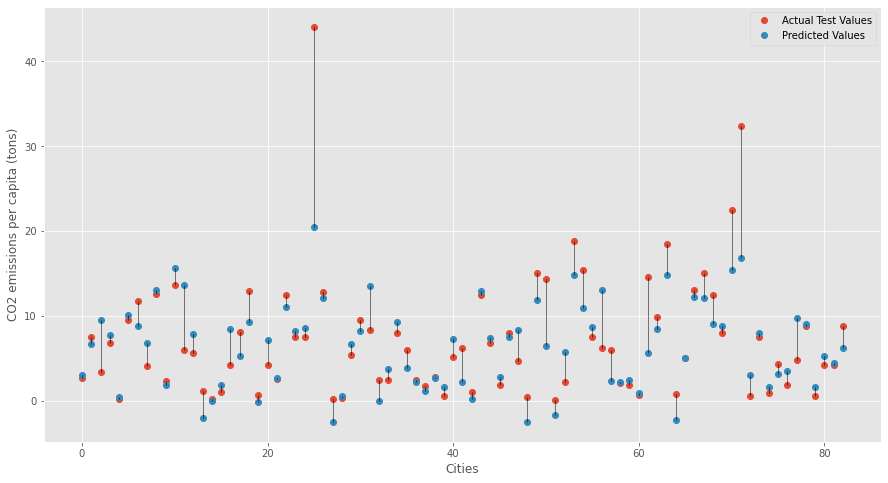

In [17]:
fig, ax = plt.subplots()
test, = ax.plot(np.arange(0,len(y_test)), y_test, label='Actual Test Values', marker='o', linestyle="None")
pred, = ax.plot(np.arange(0,len(y_test)),y_pred, label='Predicted Values', marker='o', linestyle="None")
for i in range(len(y_test)):
    ax.plot([i,i],[y_pred[i], y_test[i]], c="black", linewidth=0.5)

ax.set(xlabel='Cities', ylabel='CO2 emissions per capita (tons)',
       title='')
plt.legend(handles=[test, pred])
plt.show()




We can see that for most of the cities the predictions are fairly accurate, but we have two big outliers.
Let's take a look at what cities they are and what the prediction error is.

In [13]:
print(abs(y_test-y_pred).nlargest(n=2))

City
Edmonton           23.560861
New Orleans(LA)    15.544956
Name: CO2 Emissions per Capita (metric tonnes), dtype: float64


A visual inspection of the plot reveals how drastically different their CO2 emissions are compared to the other cities. This seemed suspicious to us and we tried verifying if the values were correct but we were unable to find anything that would allow us to discard them from the test set. Some explanation for the unusually high emission values might be that some of the main industries in Edmonton are the petrochemical and manufacturing industries which are both big polluters. The same might be true for New Orleans, as it is situated in the Gulf of Mexico and is heavily involved in off-shore oil drilling.